# 

<figure>
<img src="../Imagenes/logo-final-ap.png"  width="80" height="80" align="left"/> 
</figure>

# <span style="color:blue"><left>Aprendizaje Profundo</left></span>

# <span style="color:red"><center>Redes Generativas Adversarias</center></span>

<center>GAN</center>

##   <span style="color:blue">Autores</span>

1. Alvaro Mauricio Montenegro Díaz, ammontenegrod@unal.edu.co
1. Daniel Mauricio Montenegro Reyes, dextronomo@gmail.com 
1. Oleg Jarma, ojarmam@unal.edu.co

##   <span style="color:blue">Asesora Medios y Marketing digital</span>
 

4. Maria del Pilar Montenegro, pmontenegro88@gmail.com 

## <span style="color:blue">Referencias</span>

1. [Rowel Atiesa, Advanced Deep Learning with Tensorflow 2 and Keras, second ed., Pack, 2020](https://www.oreilly.com/library/view/advanced-deep-learning/9781838821654/)
1. [Ejemplos de Keras](https://keras.io/examples/generative/dcgan_overriding_train_step/)
1. [Tutoriales-Tensorflow](https://www.tensorflow.org/tutorials/generative/dcgan)

## <span style="color:blue">Contenido</span>

* [Introducción](#Introducción)
* [Preliminares](#Preliminares)
* [Componentes de una GAN](#Componentes-de-una-GAN)

## <span style="color:blue">Introducción</span>

¿Qué son las GAN?

Las redes generativas adversarias (GAN) son una de las más interesantes ideas de la inteligencia artificial hoy en día. Dos modelos son entrenados simultáneamente por un proceso contradictorio. Un `generador` ( "el artista") aprende a crear imágenes que parecen reales, mientras que un `discriminador` ( "el crítico de arte") aprende a decidir si las imágenes son reales o no.

El propósito del entrenamiento es que el generador aprenda a crear imágenes de tal calidad que el discriminador no logre diferenciar si son reales o `falsificaciones`. En  paralelo, el discriminador se vuelve el mejor en detectar falsificaciones.

La siguiente imagen tomada de los tutoriales de Google, ilustra los principales elementos que se requieren para construir una GAN. 

<figure>
<center>
<img src="../Imagenes/gan1.png" width="600" height="600" align="center"/>
</center>
<figcaption>
<p style="text-align:center">Generador y discriminador de una GAN </p>
</figcaption>
</figure>

Fuente: [Tutoriales-Tensorflow](https://www.tensorflow.org/tutorials/generative/dcgan)

Durante el entrenamiento, el generador se vuelve progresivamente cada vez más capaz de crear imágenes que parecen reales, mientras que el discriminador se convierte en el mejor para distinguirlas. Se alcanza una situación  de equilibrio cuando el discriminador ya no puede distinguir imágenes reales de los falsos.

<figure>
<center>
<img src="../Imagenes/gan2.png" width="500" height="400" align="center"/>
</center>
<figcaption>
<p style="text-align:center">GAN en acción </p>
</figcaption>
</figure>

Fuente: [Tutoriales-Tensorflow](https://www.tensorflow.org/tutorials/generative/dcgan)

En esta lección veremos como generar imágenes de caras usando una red generativa adversaria convolucional (DCGAN). Utilizaremos un subconjunto del conjunto de datos de imágenes de celebridades [CelebFaces Attributes (CelebA) Dataset](https://www.kaggle.com/jessicali9530/celeba-dataset) disponible en Kaggle. CelebA tiene más de 200k imágenes de celebridades con 40 anotaciones de tipo binario. Nos hemos basado en el código de F. Chollet, el creador de Keras.

## <span style="color:blue">Preliminares</span>

### Configuración

In [30]:
"""
Título: DCGAN para generar imágenes de caras
Author: [fchollet](https://twitter.com/fchollet)
Date created: 2019/04/29
Last modified: 2021/01/01
Descripción: Una  DCGAN simple entrenada `fit()` reescribiendo del paso de entrenamiento  
`train_step` de Keras sobre imágenes CelebAs.
"""
"""
## Setup
"""

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown #para bajar archivos grandes de Google-drive
from zipfile import ZipFile

### Baja el conjunto de datos y lo descomprime

In [ ]:
"""
Baja los datos CelebA del drive de Google y los coloca en un archivo 
Usaremos la imágenes de caras de CelebA dataset, colocandolas en tamaño a 64x64.
"""
# crea la carpeta en donde recibirá los datos
path = "/home/alvaro/Downloads/Data/celeba_gan/"
os.makedirs(path)

# baja los datos del drive a  la carpeta creada
url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = os.path.join(path, "data.zip")
gdown.download(url, output, quiet=True)

# extrae los archivos en la carpeta
with ZipFile(output, "r") as zipobj:
    zipobj.extractall(path)

### Crea un dataset y preprocesa los datos

Found 202599 files belonging to 1 classes.


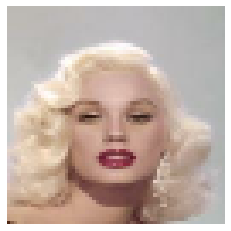

In [32]:
"""
Crea un dataset desde la carpeta los coloca las imágens en tamaño 64*64.
Finalmente re-escala las imágenes al rango [0-1]:
"""

dataset = keras.preprocessing.image_dataset_from_directory(
    path, label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)


"""
Veámos una muestra de ejemplo
"""


for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0], )
    break

## <span style="color:blue">Componentes de una GAN</span>

### Discriminador

La entrada del discriminador será datos reales o sintetizados. El discriminador recibe  muestras de datos genuinos y muestras  de datos falsos  que provienen del generador. 


Los datos válidos están etiquetados como 1.0 (es decir, un 100% de probabilidad de ser real), mientras que todos los
los datos sintetizados están etiquetados como 0.0 (es decir, un 0% de probabilidad de ser real). 


El proceso de etiquetado está automatizado, por lo que las GAN se consideran modelos de aprendizaje no supervisado. El objetivo del discriminador es aprender a  distinguir datos reales de datos falsos. Durante esta parte del entrenamiento de la GAN, solamente los parámetros del discriminador serán actualizados.

El discriminador es  un clasificador binario típico y será entrenado para predecir en un rango de 0.0 a 1.0 en valores de confianza  tan cerca de 0.0 o 1.0 como sea posible, según reciba un dato falso o uno real.

### Crea el discriminador

El discriminador es  una red convolucional de clasificación binaria , la cual asigna una imagen de 64x64 a una puntuación de clasificación binaria: real o falsa. Usaremos la función activación `LeakyReLU` para cada una de las capas internas. Esta función de activación es definida como sigue:

$$
\text{LeakyReLU}(x) = \begin{cases} x &\text{ si } x>0\\
\alpha x, \hspace{3mm}0 <\alpha < 1 &\text{ si } x\le 0 \end{cases}
$$

La siguiente función crea un discrimnador. Observe que la salida es una red neuronal creada con Keras.La siguiente función crea un generador. Observe que la salida es una red neuronal creada con Keras.

In [28]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(keras.Input(shape=(64, 64, 3)))
    model.add(layers.Conv2D(64, kernel_size=4, strides=2, padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation="sigmoid"))

    return model

discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_43 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 128)       

### Prueba del discriminador no entrenado aún

Utilizamos el discriminador, todavía no entrenado, para clasificar las imágenes generadas como reales o falsas. El modelo se entrenará para generar valores positivos para imágenes reales y valores negativos para imágenes falsas.

In [29]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.4922316]], shape=(1, 1), dtype=float32)


### Generador

La entrada al generador es ruido, y la salida son datos sintetizados. A intervalos regulares, el generador fingirá que su salida son datos genuinos y le pedirá a la GAN que lo etiquete como 1.0. Cuando los datos falsos se presentan al discriminador, naturalmente se clasificará como falso con una etiqueta cercana a 0.0.

El optimizador calcula las actualizaciones de parámetros del generador en función de lo presentado
etiqueta (es decir, 1.0). También tiene en cuenta su propia predicción cuando se entrena con esta nueva información.  En otras palabras, el discriminador tiene algunas dudas con respecto a su predicción, y así, la GAN toma eso en consideración.

La siguiente función crea un generador. Observe que la salida es una red neuronal creada con Keras.

In [22]:
def make_generator_model(latent_dim=128):
    model = tf.keras.Sequential()
    model.add(keras.Input(shape=(latent_dim,)))
    model.add(layers.Dense(8*8*latent_dim))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Reshape((8, 8, latent_dim)))
    assert model.output_shape == (None, 8, 8, latent_dim)  # Note: None is el tamaño del batch 

    model.add(layers.Conv2DTranspose(latent_dim, kernel_size=4, strides=2, padding="same", use_bias=False))
    assert model.output_shape == (None, 16, 16, latent_dim)

    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2DTranspose(latent_dim*2, kernel_size=4, strides=2, padding="same", use_bias=False))
    assert model.output_shape == (None, 32, 32, latent_dim*2)
    
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2DTranspose(latent_dim*4, kernel_size=4, strides=2, padding="same", use_bias=False))
    assert model.output_shape == (None, 64, 64, latent_dim*4)
    
    
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid", use_bias=False))
    #assert model.output_shape == (None, 64, 64, 3)

    return model

generator = make_generator_model()
generator.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 8192)              1056768   
_________________________________________________________________
batch_normalization_25 (Batc (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
reshape_9 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_23 (Conv2DT (None, 16, 16, 128)       262144    
_________________________________________________________________
batch_normalization_26 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 16, 16, 128)      

### Prueba del generador aún no  entrenado

Usamos el generador, todavía no entrenado, para crear una imagen.

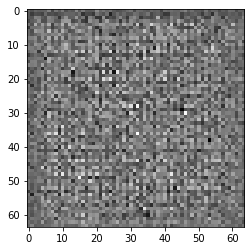

In [23]:
generator = make_generator_model()

noise = tf.random.normal([1, 128])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## <span style="color:blue">Redes competitivas o colaborativas</span>

En general, todo el proceso es similar a dos redes que compiten entre sí mientras siguen cooperando al mismo tiempo. Cuando el entrenamiento de GAN converge, al final el resultado es un generador que puede sintetizar datos que parecen genuinos. 

El discriminador piensa que estos datos sintetizados son reales o con una etiqueta cercana a 1.0, lo que significa que el discriminador puede ser descartado. La parte del generador será útil para producir salidas significativas de entradas de ruido arbitrarias.

La siguiente imagen describe el proceso de entrenamiento de una GAN

<figure>
<center>
<img src="../Imagenes/GAN_trainig.png" width="600" height="600" align="center"/>
</center>
<figcaption>
<p style="text-align:center">Esquema de entrenamiento de una GAN </p>
</figcaption>
</figure>

## <span style="color:blue">Reescritura o sobrecarga algunos métodos de keras.Model</span>

Entrenar una GAN requiere que se reescriba el paso de entrenamiento de la red. Esto es necesario, debido a que tenemos dos redes compitiendo que deben entrenarse simultáneamente.

Lo que haremos es lo siguiente. Creamos una clase que llamaremos GAN y que derivamos de la clase `keras.Model`. Recuerde que Model contiene los métodos completos para entrenar una red neuronal, pero podemos reescribir algunos de sus métodos. Reescribimos los métodos `__init__()`, `compile()` y `train_step()`.

#### Método \_\_init\_\_()

Define los objetos discriminador y generador y el tmaño del espacio latente de representación interna de las imágenes.

#### Método compile()

Debido aque entrenamos dos redes simultáneamente, cada una debe tener su propio optimizador y su propia función de pérdida. Esta implementación usaremos el  mismo  tipo de función de pérdida, pero permitimos optimizadores diferentes. Definimos métricas diferenciadas basadas en la función de pérdida de cada red. En este caso será el mismo tipo de función de pérdida, pero cada red tiene su propia pérdida.

### Propiedad *metrics*

Para facilitar la implementación definimos esta propiedad de tal forma que sea la lista conformada por las métricas que definimos en el método *compile()* para cada red.

### Método *train_step()*

Redefinir el paso de entrenamiento es el principal ingrediente de las GAN. Se siguen los siguientes pasos:


1.  A la entrada la función recibe, como siempre ocurre, un lote (batch) de imágenes de entrenamiento reales.
1. Genera un lote (batch) de puntos aleatorios del mismo tamaño del lote de entrada a la función.  Supongamos que el tamaño del espacio latente de representación es de tamaño $n$. Entonces genera un lotes de observaciones usando la distribución normal multivariada estándar $\mathfrak{N}_n(\boldsymbol{0},\boldsymbol{I})$.
1. Con el lote de aleatorios usa el generador para generar un lote de imágenes falsas.
1. Combina (concatena) los dos lotes: imágenes falsas generadas e imágenes reales.
1.  Etiqueta todas las imágenes, discriminado las reales de las falsas.
1. Agrega ruido aleatorio a las etiquetas: ¡truco importante!. Esto hará que el discriminador reciba de vez en cuando información totalmente cambiada. En particular algunas etiquetas falsas se verán como verdaderas y viceversa. Se pretende con esto engañar al discriminador. Revise la siguiente imagen.
1. Entrena al discriminador. Se pasan las imágenes combinadas al discriminador para que prediga las respectivas etiquetas. Con estas predicciones se calcula la pérdida del discriminador y se actualizan sus pesos (parámetros). El generador permanece ajeno a este proceso.
1. Genera un nuevo lote de aleatorios como se hizo arriba.
1. Etiqueta todas esta imágenes  diciendo que todas son "imágenes reales"
1. Entrena el generador (tenga en cuenta que **no** debemos actualizar los pesos del discriminador en este paso). Los aleatorios son pasados por el generador y entregados al discriminador, el cual hace la predicción. La función de pérdida del generador hace el mismo trabajo que hace la función de pérdida del discriminador (*entropía cruzada*), pero aquí las etiquetas de las imágenes falsas se colocaron como verdaderas, obligando al generador a hacer mejor el trabajo de falsificación.
1. Eso es todo. Al final se re-calculan las métricas y se retornan.

<figure>
<center>
<img src="../Imagenes/gan_training2.png" width="400" height="600" align="center"/>
</center>
<figcaption>
<p style="text-align:center">Entradas al discriminador </p>
</figcaption>
</figure>

Fuente [Soumith, How to Train a GAN? Tips and tricks to make GANs workHow to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks/blob/master/README.mdhttps://github.com/soumith/ganhacks/blob/master/README.md), in Github.

In [34]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
    
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")
        

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Genera un lote (batch) de puntos aleatorios de dimensión latent_dim,
        # usando un modelo normal estándar: N_{latent_dim}(0, I).
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decodifica los puntos aleatorios como imágenes falsas (fake images)
        generated_images = self.generator(random_latent_vectors)

        # Combina los dos lotes de imágenes (generadas (falsas) y reales)
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Etiqueta todas las imágenes, discriminado las reales de las falsas
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Agrega ruido aleatorio a las etiquetas: ¡truco importante!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Entrena al discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Genera un nuevo lote de aleatorios como se hizo arriba.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Etiqueta todas esta imágenes  diciendo que todas son "imágenes reales"
        misleading_labels = tf.zeros((batch_size, 1))

        # Entrena el generador (tenga en cuenta que * no * debemos actualizar los pesos
        # del discriminador)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


### Crea un callback que periodicamente graba imagenes generadas

Paar poder monitorear en línea el proceso de entrenamiento, Al final de cada época se generan algunas imágenes aleatoriament. En este ejercicio hemos generado 10 imágenes en cada paso.

In [35]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("../Datos/generated_img_%03d_%d.png" % (epoch, i))


### Entrena el modelo de lado a lado

Con todo lo anterior, así podemos entrenar nuesto modelo.

In [ ]:
epochs = 100  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)


Epoch 1/100
   6/6332 [..............................] - ETA: 31:08:12 - d_loss: 0.6746 - g_loss: 0.8158

### Imágenes generadas

In [ ]:
Estas son algunas de las imágenes que se generaron durante el entrenamiento.

In [ ]:
# Display a single image using the epoch number
import matplotlib.pyplot as plt
from PIL import Image

def display_images(epoch, num_img=10): 
    f, axs = plt.subplots(epoch,num_img,figsize=(10,10))
    for j in range(epoch):
        for i in range(num_img):
          axs[j,i].imshow(Image.open("../Datos/Datos/generated_img_%03d_%d.png" % (j, i)))
          axs[j,i].axis('off')


display_images(40)
